## Step 2: Data Exploration:

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import seaborn as sns
import cv2
from collections import Counter

In [2]:
# Define dataset path
dataset_path = "EuroSAT/2750/"

In [3]:
# List all land type categories
categories = os.listdir(dataset_path)

## Step 3: Data Preprocessing

In [4]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# Resize, normalize, and convert to RGB
def load_and_preprocess_images(path, size=(224, 224)):
    data, labels = [], []
    for category in categories:
        category_path = os.path.join(path, category)
        for img_name in os.listdir(category_path):
            img = cv2.imread(os.path.join(category_path, img_name))
            img = cv2.resize(img, size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            img = img / 255.0  # Normalize to [0,1]
            data.append(img)
            labels.append(category)
    return np.array(data, dtype="float32"), np.array(labels)

In [6]:
# Load data
data, labels = load_and_preprocess_images(dataset_path)

In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
# Encode labels into integers
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)  # Convert category names to integer labels

In [9]:
# Convert to one-hot encoding
labels_categorical = to_categorical(labels_encoded)

In [19]:
# Split dataset into train (70%), validation (20%), and test (10%)
X_train, X_temp, y_train, y_temp = train_test_split(data, labels_categorical, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, random_state=42)

In [20]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
)

# datagen = ImageDataGenerator(
#     rotation_range=25,    # Slightly increased, but not too much
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True,
#     shear_range=0.1  # Just a little shear (not too aggressive)
# )


# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     zoom_range=0.2,
#     shear_range=0.15,   # Skewing effect for robustness
# )

In [21]:
val_test_datagen = ImageDataGenerator()

# Final datasets
train_generator = datagen.flow(X_train, y_train, batch_size=32, shuffle=True)
val_generator = val_test_datagen.flow(X_val, y_val, batch_size=32, shuffle=False)
test_generator = val_test_datagen.flow(X_test, y_test, batch_size=32, shuffle=False)

# Step 4: Modelling:

### settings

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [24]:
# Function to Evaluate Keras Model
def evaluate_model(model, X_test, y_test, class_names):
    # Get model predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels
    y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

    # Compute accuracy
    accuracy = accuracy_score(y_true, y_pred) * 100  # Convert to percentage

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    # Print classification report
    print(classification_report(y_true, y_pred, target_names=class_names))
    print(f"Final Accuracy: {accuracy:.2f}%")  # Print final accuracy

## CNN Model

In [17]:
# Define CNN model with best parameters
def build_model():
    model = models.Sequential([
        layers.Input(shape=(224, 224, 3)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.4),
        layers.Dense(len(categories), activation='softmax')
    ])

    # Compile model with best learning rate
    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

### 64 resizing

In [22]:
# model building
model = build_model()

# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    train_generator,
    epochs=60,  # Train longer since we have the best model
    validation_data=val_generator,
    callbacks=[early_stopping]
)

Epoch 1/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 254s 427ms/step - accuracy: 0.3003 - loss: 1.8030 - val_accuracy: 0.6293 - val_loss: 1.0199
Epoch 2/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 252s 425ms/step - accuracy: 0.6292 - loss: 1.0339 - val_accuracy: 0.7402 - val_loss: 0.7247
Epoch 3/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 257s 435ms/step - accuracy: 0.7037 - loss: 0.8524 - val_accuracy: 0.7876 - val_loss: 0.5946
Epoch 4/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 253s 427ms/step - accuracy: 0.7507 - loss: 0.7183 - val_accuracy: 0.8074 - val_loss: 0.5477
Epoch 5/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 252s 427ms/step - accuracy: 0.7741 - loss: 0.6511 - val_accuracy: 0.8274 - val_loss: 0.4871
Epoch 6/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 252s 426ms/step - accuracy: 0.8022 - loss: 0.5828 - val_accuracy: 0.8433 - val_loss: 0.4591
Epoch 7/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 250s 422ms/step - accuracy: 0.8232 - loss: 0.5117 - val_accuracy: 0.8870 - val_loss: 0.3254
Epoch 8/60
591/591 ━━━━━━━━━━━━━━━━━━━━ 252s 426ms/step - accuracy: 0.8416 -

85/85 ━━━━━━━━━━━━━━━━━━━━ 9s 107ms/step


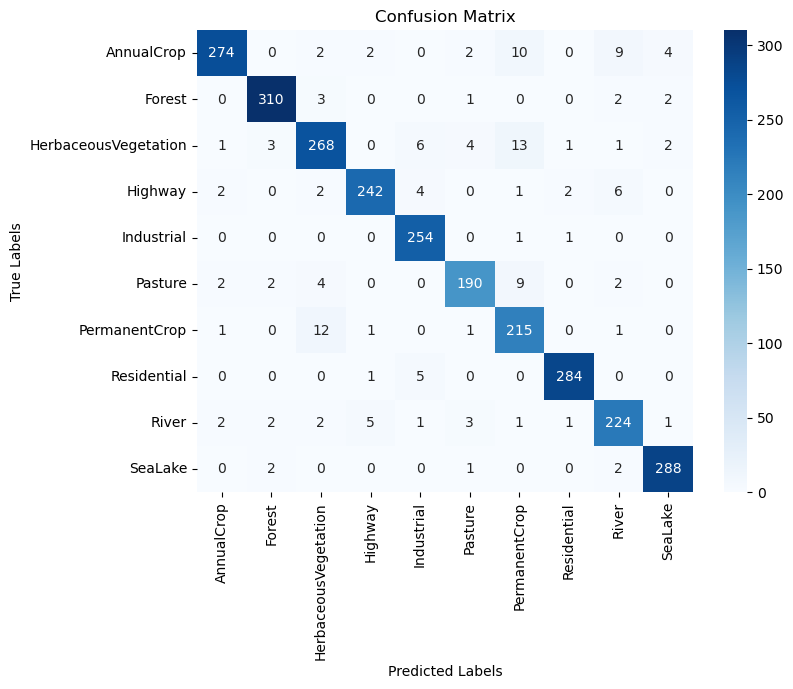

                      precision    recall  f1-score   support

          AnnualCrop       0.97      0.90      0.94       303
              Forest       0.97      0.97      0.97       318
HerbaceousVegetation       0.91      0.90      0.91       299
             Highway       0.96      0.93      0.95       259
          Industrial       0.94      0.99      0.97       256
             Pasture       0.94      0.91      0.92       209
       PermanentCrop       0.86      0.93      0.89       231
         Residential       0.98      0.98      0.98       290
               River       0.91      0.93      0.92       242
             SeaLake       0.97      0.98      0.98       293

            accuracy                           0.94      2700
           macro avg       0.94      0.94      0.94      2700
        weighted avg       0.94      0.94      0.94      2700

Final Accuracy: 94.41%


In [25]:
evaluate_model(model, X_test, y_test, class_names=categories)

In [ ]:
model.save('model.h5')

### 128 resizing

85/85 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step


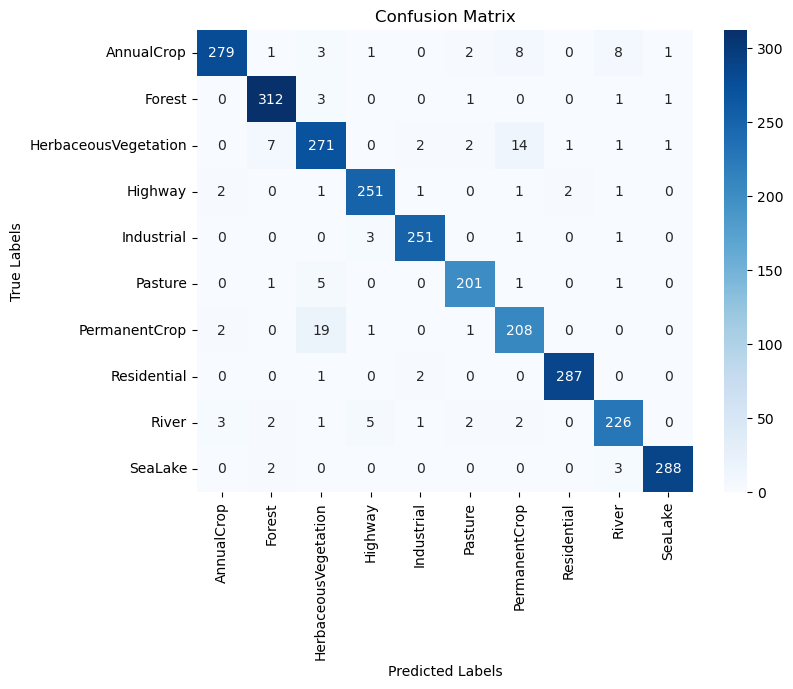

                      precision    recall  f1-score   support

          AnnualCrop       0.98      0.92      0.95       303
              Forest       0.96      0.98      0.97       318
HerbaceousVegetation       0.89      0.91      0.90       299
             Highway       0.96      0.97      0.97       259
          Industrial       0.98      0.98      0.98       256
             Pasture       0.96      0.96      0.96       209
       PermanentCrop       0.89      0.90      0.89       231
         Residential       0.99      0.99      0.99       290
               River       0.93      0.93      0.93       242
             SeaLake       0.99      0.98      0.99       293

            accuracy                           0.95      2700
           macro avg       0.95      0.95      0.95      2700
        weighted avg       0.95      0.95      0.95      2700

Final Accuracy: 95.33%


In [20]:
evaluate_model(model1, X_test, y_test, class_names=categories)

In [21]:
model1.save('model1.h5')

### 224 resizing

85/85 ━━━━━━━━━━━━━━━━━━━━ 27s 317ms/step


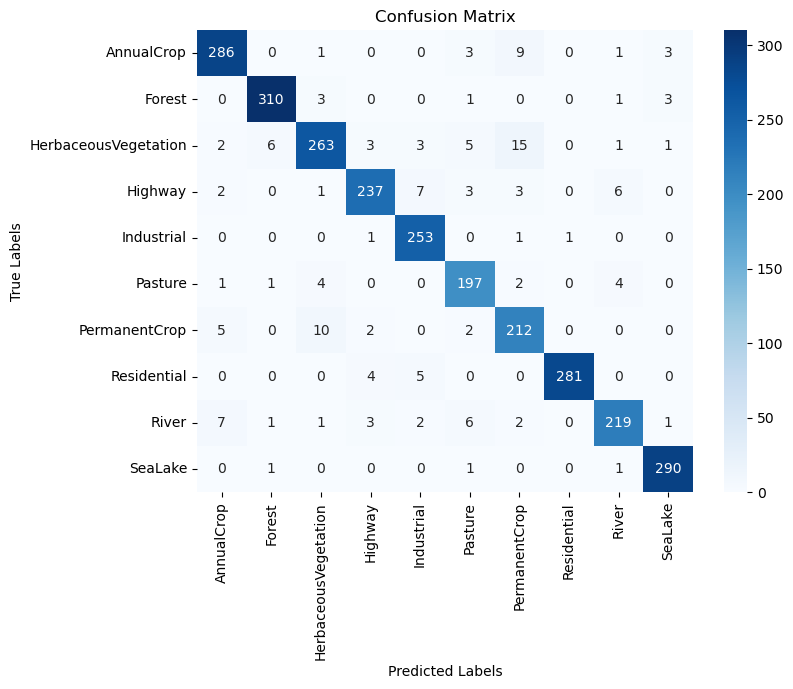

                      precision    recall  f1-score   support

          AnnualCrop       0.94      0.94      0.94       303
              Forest       0.97      0.97      0.97       318
HerbaceousVegetation       0.93      0.88      0.90       299
             Highway       0.95      0.92      0.93       259
          Industrial       0.94      0.99      0.96       256
             Pasture       0.90      0.94      0.92       209
       PermanentCrop       0.87      0.92      0.89       231
         Residential       1.00      0.97      0.98       290
               River       0.94      0.90      0.92       242
             SeaLake       0.97      0.99      0.98       293

            accuracy                           0.94      2700
           macro avg       0.94      0.94      0.94      2700
        weighted avg       0.94      0.94      0.94      2700

Final Accuracy: 94.37%


In [25]:
evaluate_model(model2, X_test, y_test, class_names=categories)

In [26]:
model2.save('model2.h5')